In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
def simulate_boltzmann(weights):
    return random.choices(np.arange(len(weights)), weights)[0]

In [3]:
class arm():
    # we have object arm that is used to generate reward specifically. It might contain some parameters
    
    # for each problem, we need to write specific arm class which is child of this arm class.
    def __init__(self):
        
        raise Exception("not implemented")
        
    def pull_reward(self):
        
        raise Exception("not implemented")
        

In [4]:
class k_armed_bandit():
    
    def __init__(self, list_arms, t):
        
        # variables: 
        
            # list_arms: list of k arms where each arm is object arm. arm has its own methods
            #            for example to generate reward.
            
            # k is number of arms
            
           
        self.k = len(list_arms)
        self.t = t # time horizon
        self.list_arms = list_arms
    
    
    def greedy(self, show = False):
    
        # runs greedy apporach  
    
        
        u_estimated = np.abs(np.random.normal(size = self.k)) # each arm is indexed, and for each arm we keep track
                                                    # of estimated utility values,i.e. expected reward given that action
        count_arms = np.zeros(self.k) # for each arm we store number of times we chose that
                                    # arm before time t
        rewards = np.zeros(self.t) 
        # start game 
        for iteration in range(self.t):
            #simulate action 
            arm_chosen_index = np.argmax(u_estimated) # this is index of chosen arm
            
            count_arms[arm_chosen_index] += 1
    
            #simulate reward from chosen arm
            new_reward = self.list_arms[arm_chosen_index].pull_reward()
            rewards[iteration] = new_reward

            #update estimated values at chosen action

            step_size = 1 / count_arms[arm_chosen_index]
            u_estimated[arm_chosen_index] += step_size * (new_reward - u_estimated[arm_chosen_index])
        if show:
            min_action = np.argmin(count_arms)
            min_visits = np.min(count_arms)
            
            max_action = np.argmax(count_arms)
            max_visits = np.max(count_arms)
            print(f"action {min_action} has minimum number of visits is {min_visits}")
            print(f"action {max_action} has maximum number of visits is {max_visits}")
            #plt.plot(count_arms,"o")
        return (u_estimated, rewards)
        
        
    
    
    def eps_greedy(self, epsilon, show = False):
        
        # runs epsilon greedy approach
        
        
        
        
        u_estimated = np.random.normal(size = self.k) # each arm is indexed, and for each arm we keep track
                                                    # of estimated utility values,i.e. expected reward given that action
        count_arms = np.zeros(self.k) # for each arm we store number of times we chose that
                                    # arm before time t
            
        rewards = np.zeros(self.t)
        # start game  
        for i in range(self.t):
            #simulate action 
            r = np.random.rand()

            if r < epsilon: # with epsilon probability we choose action uniformly
                arm_chosen_index = np.random.choice(np.arange(self.k))
            else:
                arm_chosen_index = np.argmax(u_estimated)
            count_arms[arm_chosen_index] += 1


            #simulate reward 
            new_reward = self.list_arms[arm_chosen_index].pull_reward()
            rewards[i] = new_reward

            #update estimated values at chosen action
            step_size = 1 / count_arms[arm_chosen_index]
            u_estimated[arm_chosen_index] += step_size * (new_reward - u_estimated[arm_chosen_index])
            
        if show:
            min_action = np.argmin(count_arms)
            min_visits = np.min(count_arms)
            
            max_action = np.argmax(count_arms)
            max_visits = np.max(count_arms)
            print(f"action {min_action} has minimum number of visits is {min_visits}")
            print(f"action {max_action} has maximum number of visits is {max_visits}")
        
        return (u_estimated, rewards)
    
    
    
    def gradient_algorithm(self, show = False):
        
        # runs gradient based algorithm
        # we put weights to each arm and then update them iteratively.
        

       
        weights = np.ones(self.k) # at the begining we put uniform weights, this weights generate
                                                # probability distribution over arms
        probabilities = np.exp(weights)  # during iterations this is probabilities weights
                                                    # up to normalizing constant
        rewards = np.zeros(self.t)
        
        average_rewards = 0
        count_arms = np.zeros(self.k)
        
        
        
        for i in range(self.t):
            
            arm_chosen_index = simulate_boltzmann(probabilities) # this function gives us integer from 1,... K according to boltzman
                                                # probability distribution
            
            # simulate reward
            
            new_reward = self.list_arms[arm_chosen_index].pull_reward()
            rewards[i] = new_reward
            
            count_arms[arm_chosen_index] += 1
            
            
            # update weights, average reward, and probabilities
            
            weights[arm_chosen_index] += (new_reward - average_rewards) * (1 - probabilities[arm_chosen_index])
            mask = np.full(self.k, True, dtype=bool) # we update every other action
            mask[arm_chosen_index] = False
            
            weights[mask] -= (new_reward - average_rewards) * probabilities[mask]
            probabilities = np.exp(weights)
            average_rewards = i * average_rewards / (i + 1) + new_reward / (i + 1)
            
            
        if show:
            min_action = np.argmin(count_arms)
            min_visits = np.min(count_arms)
            
            max_action = np.argmax(count_arms)
            max_visits = np.max(count_arms)
            print(f"action {min_action} has minimum number of visits is {min_visits}")
            print(f"action {max_action} has maximum number of visits is {max_visits}")
            plt.plot(count_arms,"o")
        
        
        return (weights, rewards)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def macau(self, beta_list, mcmc_steps, show = False ):
        
        
        # variables: 
            
            # beta_list: list of inverse temperatures in increasing order
            # mcmc_steps: number of times we perform steps per each temperature
            
         
        # returns estimated utilites and rewards for each chosen action
        
        
        u_estimated = np.random.normal(size = self.k) # each arm is indexed, and for each arm we keep track
                                                    # of estimated utility values,i.e. expected reward given that action
        count_arms = np.zeros(self.k) # for each arm we keep track of number of times that arm
                                      # is chosen
            
        rewards = np.zeros(len(beta_list) * mcmc_steps)
        
        current_arm_index = np.random.randint(0, self.k) # index for the arm
        iteration = 0 # keep track of number of times we simulate game
        for beta in beta_list:
            
            accept_rate = 0.0   # acceptance rate for each beta
            
            for steps in range(mcmc_steps):
                
                # 1) optimization step
                # propose arm
                
                proposed_arm_index = np.random.randint(0, self.k) # index for the arm
                
                # accept/reject
                
                if u_estimated[proposed_arm_index] >= u_estimated[current_arm_index]:
                    # accept
                    accept_rate += 1
                    current_arm_index = proposed_arm_index
                    
                else:
                    acceptance_prob = np.exp(beta * (u_estimated[proposed_arm_index] - u_estimated[current_arm_index]))
                    if np.random.rand() < acceptance_prob:
                        # accept
                        accept_rate += 1
                        current_arm_index = proposed_arm_index
                    # else we reject move
                
                
                # 2) update knowledge step
                count_arms[current_arm_index] += 1
                
                # generate reward
                rewards[iteration] = self.list_arms[current_arm_index].pull_reward()
                
                # update estimated utilities if 
                
                step_size = 1 / count_arms[current_arm_index]
                u_estimated[current_arm_index] +=  step_size * (rewards[iteration] - u_estimated[current_arm_index])
                
                    
                iteration += 1
            #if show:
                #print(f"for beta {beta} acceptance rate is : {accept_rate/mcmc_steps}")
        if show:
            min_action = np.argmin(count_arms)
            min_visits = np.min(count_arms)
            
            max_action = np.argmax(count_arms)
            max_visits = np.max(count_arms)
            print(f"action {min_action} has minimum number of visits is {min_visits}")
            print(f"action {max_action} has maximum number of visits is {max_visits}")
            plt.plot(count_arms,"o")
        return (u_estimated, rewards)
                
            
        
    def ucb_macau(self, beta_list, mcmc_steps, c, show = False ):
        
        
        # variables: 
            
            # beta_list: list of inverse temperatures in increasing order
            # mcmc_steps: number of times we perform steps per each temperature
            # c : confidence parameter
         
        # returns estimated utilites and rewards for each chosen action
        
        
        u_estimated = np.random.normal(size = self.k) # each arm is indexed, and for each arm we keep track
                                                    # of estimated utility values,i.e. expected reward given that action
        count_arms = np.zeros(self.k) # for each arm we keep track of number of times that arm
                                      # is chosen
            
        rewards = np.zeros(len(beta_list) * mcmc_steps)
        
        current_arm_index = np.random.randint(0, self.k) # index for the arm
        iteration = 0 # keep track of number of times we simulate game
        for beta in beta_list:
            
            accept_rate = 0.0   # acceptance rate for each beta
            
            for steps in range(mcmc_steps):
                
                # 1) optimization step
                # propose arm
                
                proposed_arm_index = np.random.randint(0, self.k) # index for the arm
                
                # accept/reject
                
                if u_estimated[proposed_arm_index] + c * np.sqrt(np.log(self.t) / (1 + count_arms[proposed_arm_index])) >= u_estimated[current_arm_index] + c * np.sqrt(np.log(self.t) / (1 + count_arms[current_arm_index])):
                    # accept
                    accept_rate += 1
                    current_arm_index = proposed_arm_index
                    
                else:
                    acceptance_prob = np.exp(beta * (u_estimated[proposed_arm_index] + c * np.sqrt(np.log(self.t) / (1 + count_arms[proposed_arm_index])) - u_estimated[current_arm_index] - c * np.sqrt(np.log(self.t) / (1 + count_arms[current_arm_index]))))
                    if np.random.rand() < acceptance_prob:
                        # accept
                        accept_rate += 1
                        current_arm_index = proposed_arm_index
                    # else we reject move
                
                
                # 2) update knowledge step
                count_arms[current_arm_index] += 1
                
                # generate reward
                rewards[iteration] = self.list_arms[current_arm_index].pull_reward()
                
                # update estimated utilities if 
                
                step_size = 1 / count_arms[current_arm_index]
                u_estimated[current_arm_index] +=  step_size * (rewards[iteration] - u_estimated[current_arm_index])
                
                    
                iteration += 1
            #if show:
                #print(f"for beta {beta} acceptance rate is : {accept_rate/mcmc_steps}")
        if show:
            min_action = np.argmin(count_arms)
            min_visits = np.min(count_arms)
            
            max_action = np.argmax(count_arms)
            max_visits = np.max(count_arms)
            print(f"action {min_action} has minimum number of visits is {min_visits}")
            print(f"action {max_action} has maximum number of visits is {max_visits}")
            plt.plot(count_arms,"o")
        return (u_estimated, rewards)
                
            
        
    

# arms that have normally distributed rewards



In [5]:
class normal_rewards_arm(arm):
    
    def __init__(self, mean, sd):
        self.mean = mean
        self.sd = sd
        self.params = (mean,sd)
        
    def pull_reward(self):
        
        return np.random.normal(self.mean, self.sd)
        

In [6]:
k = 2000
np.random.seed(1020)


# for each arm mean is uniformly chosen from (0,2) and sd is uniformly chosen from (1,2)
parameters = np.column_stack((20 * np.random.rand(k), np.random.rand(k) + 0.5))

list_arms = [normal_rewards_arm(mean,sd) for (mean,sd) in parameters]

mcmc_steps = 5000
beta_list = np.linspace(0, 100, 100)
t = len(beta_list) * mcmc_steps

epsilon = 0.01
confidence = 0.1

# define k armed bandit problem

armed_bandit = k_armed_bandit(list_arms, t)


u_mean = parameters[:,0]

# run simulated annealing algorithm

In [7]:
start_time = time.time()
u_estimated_greedy, rewards_greedy = armed_bandit.greedy(True)
print(f"time for algorithm : {time.time() - start_time}")

action 0 has minimum number of visits is 0.0
action 339 has maximum number of visits is 500000.0
time for algorithm : 4.311795949935913


In [8]:
start_time = time.time()
u_estimated_eps_greedy, rewards_eps_greedy = armed_bandit.eps_greedy(epsilon, True)
print(f"time for algorithm : {time.time() - start_time}")

action 12 has minimum number of visits is 0.0
action 1036 has maximum number of visits is 490652.0
time for algorithm : 4.906010866165161


action 18 has minimum number of visits is 0.0
action 1920 has maximum number of visits is 191176.0
time for algorithm : 6.199429750442505


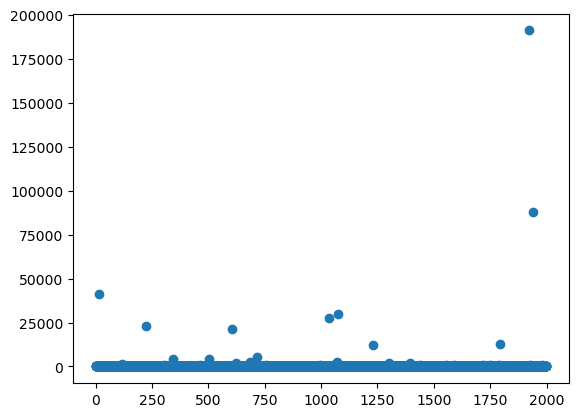

In [9]:
start_time = time.time()
u_estimated_macau, rewards_macau = armed_bandit.macau(beta_list,mcmc_steps, True)
print(f"time for algorithm : {time.time() - start_time}")

In [10]:
start_time = time.time()
u_estimated_ucb_macau, rewards_ucb_macau = armed_bandit.ucb_macau(beta_list,mcmc_steps, True)
print(f"time for algorithm : {time.time() - start_time}")

time for algorithm : 16.67761206626892


action 0 has minimum number of visits is 0.0
action 1810 has maximum number of visits is 500000.0
time for algorithm : 108.8263349533081


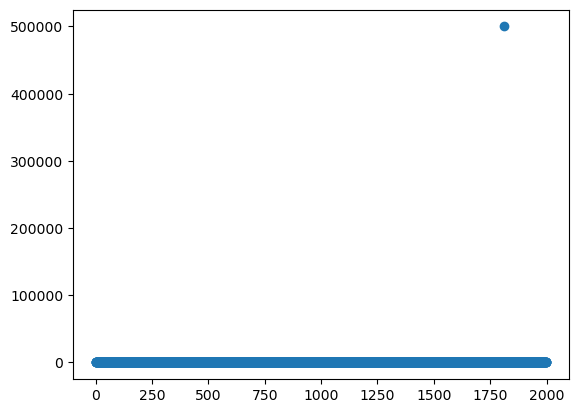

In [11]:
start_time = time.time()
weights, rewards_gradient = armed_bandit.gradient_algorithm(True)
print(f"time for algorithm : {time.time() - start_time}")

In [12]:
u_mean.argmax()

1920

In [13]:
u_mean.min()

0.014108679361903853

In [14]:
(u_estimated_ucb_macau - u_mean).sum()

-1698.5424508635947

In [15]:
u_mean.var()

32.830263516861976

In [16]:
u_estimated_macau.var()

37.87535499251478

In [17]:
total_rewards = rewards_greedy.sum()
print(f"regret is {u_mean.max()  - total_rewards / t}")

regret is 12.954300028204958


In [18]:
total_rewards = rewards_eps_greedy.sum()
print(f"regret is {u_mean.max()  - total_rewards / t}")

regret is 0.1477342362002041


In [19]:
total_rewards = rewards_macau.sum()
print(f"regret is {u_mean.max()  - total_rewards / t}")

regret is 0.146560172567753


In [20]:
total_rewards = rewards_ucb_macau.sum()
print(f"regret is {u_mean.max()  - total_rewards / t}")

regret is 0.17054893502976753


In [21]:
total_rewards = rewards_gradient.sum()
print(f"regret is {u_mean.max()  - total_rewards / t}")

regret is 6.022833400835422


In [22]:
#plt.plot(rewards_greedy.cumsum())
#plt.plot(rewards_eps_greedy.cumsum(), color = 'black')
#plt.plot(rewards_macau.cumsum())
#plt.plot(rewards_ucb_macau.cumsum(), color = "yellow")